In [1]:
import lightgbm as lgb
import pandas as pd 
import numba
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
import shap

In [65]:
df=pd.read_csv('top10.csv',';')
df=df[df['store_name']=='Аэрофлот']

In [66]:
df['store_name'].unique()

array(['Аэрофлот'], dtype=object)

In [67]:
df.columns

Index(['Unnamed: 0', 'purchdate', 'amount', 'mcc', 'mrchcity', 'mrchname',
       'cnum', 'store_name', 'merchant_name', 'category_x', 'cnum_',
       'categorycode', 'gender', 'age', 'married_', 'residenttype',
       'category_y', 'description'],
      dtype='object')

# Формируем признаки и обработка данных

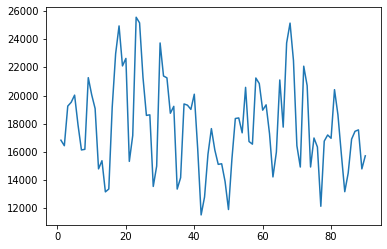

In [76]:
df_amount=df.groupby(by='purchdate',as_index=False)['amount'].sum()
df_amount=df_amount[1:-2]
plt.plot(df_amount['amount'])

In [82]:
a=[1,2,3,4,5,6,7]*50
a=a[:len(df_amount['amount'])]
df_amount['day']=a
df_amount['lag_t1']=df_amount['amount'].shift(1)
df_amount['lag_t2']=df_amount['amount'].shift(2)
df_amount['lag_t3']=df_amount['amount'].shift(3)
df_amount['lag_t4']=df_amount['amount'].shift(4)
df_amount['lag_t5']=df_amount['amount'].shift(5)
df_amount=df_amount.dropna()

In [90]:
df_amount

,purchdate,amount,day,lag_t1,lag_t2,lag_t3,lag_t4,lag_t5
11,2019-09-25 00:00:00,19078.464,6,20052.784,21273.872,16178.997,16135.803,17914.712
12,2019-09-26 00:00:00,14789.872,7,19078.464,20052.784,21273.872,16178.997,16135.803
13,2019-09-27 00:00:00,15370.301,1,14789.872,19078.464,20052.784,21273.872,16178.997
14,2019-09-28 00:00:00,13154.385,2,15370.301,14789.872,19078.464,20052.784,21273.872
15,2019-09-29 00:00:00,13358.429,3,13154.385,15370.301,14789.872,19078.464,20052.784
...,...,...,...,...,...,...,...,...
86,2019-12-09 00:00:00,16901.764,4,14491.431,13167.261,15844.085,18639.511,20421.532
87,2019-12-10 00:00:00,17461.253,5,16901.764,14491.431,13167.261,15844.085,18639.511
88,2019-12-11 00:00:00,17562.112,6,17461.253,16901.764,14491.431,13167.261,15844.085
89,2019-12-12 00:00:00,14788.032,7,17562.112,17461.253,16901.764,14491.431,13167.261


In [83]:
X_train=df_amount[:int(len(df_amount)*0.6)][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_train=df_amount[:int(len(df_amount)*0.6)][['amount']]
X_test=df_amount[int(len(df_amount)*0.6):int(len(df_amount)*0.9)][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_test=df_amount[int(len(df_amount)*0.6):int(len(df_amount)*0.9)][['amount']]
X_val=df_amount[int(len(df_amount)*0.9):][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_val=df_amount[int(len(df_amount)*0.9):][['amount']]

# Прогноз для всего набора данных

In [84]:
gbm=FitGBM(X_train,Y_train,X_test,Y_test) 

learning rate:  0.1
power:  5000
objective:  tweedie
boosting_type:  gbdt
Fit model...
Training until validation scores don't improve for 100 rounds
[100]	training's tweedie: 533.566	valid_1's tweedie: 541.767
[200]	training's tweedie: 533.461	valid_1's tweedie: 541.723
[300]	training's tweedie: 533.401	valid_1's tweedie: 541.754
Early stopping, best iteration is:
[211]	training's tweedie: 533.453	valid_1's tweedie: 541.719
Our val rmse score is 2460.516294491225


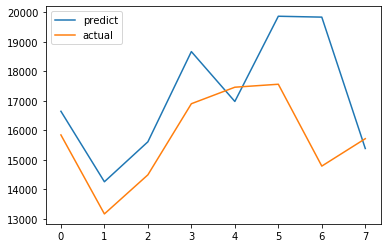

In [85]:
predict=gbm.predict(X_val)
plt.plot(predict,label='predict')
plt.plot(Y_val.values,label='actual')
plt.legend()
plt.show()

In [95]:
df_res=pd.DataFrame()
df_res['Predict']=predict
df_res['Actual']=Y_val.values
df_res['Date']=df_amount[int(len(df_amount)*0.9):]['purchdate'].values

In [96]:
df_res.to_csv('result.csv',';')

,Predict,Actual,Date
0,16645.395268,15844.085,2019-12-06 00:00:00
1,14257.066634,13167.261,2019-12-07 00:00:00
2,15611.129230,14491.431,2019-12-08 00:00:00
3,18668.458843,16901.764,2019-12-09 00:00:00
4,16978.252057,17461.253,2019-12-10 00:00:00
5,19866.668273,17562.112,2019-12-11 00:00:00
6,19836.593813,14788.032,2019-12-12 00:00:00
7,15384.164993,15716.729,2019-12-13 00:00:00


In [64]:
print('Mape: ')
print(int(mean_absolute_percentage_error(Y_val.values,predict)*100),'%')

Mape: 
10 %


# Прогноз в разрезе пола

learning rate:  0.1
power:  5000
objective:  rmse
boosting_type:  gbdt
Fit model...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1210.63	valid_1's rmse: 1603.12
Early stopping, best iteration is:
[61]	training's rmse: 1248.07	valid_1's rmse: 1580.3
Our val rmse score is 1580.300044513321


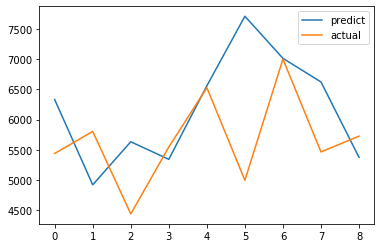

Mape: 
16 %


In [74]:
df_amount=df[df['gender']=='F'].groupby(by='purchdate',as_index=False)['amount'].sum()
df_amount=df_amount[1:-2]
a=[1,2,3,4,5,6,7]*50
a=a[:len(df_amount['amount'])]

df_amount['day']=a
df_amount['lag_t1']=df_amount['amount'].shift(1)
df_amount['lag_t2']=df_amount['amount'].shift(2)
df_amount['lag_t3']=df_amount['amount'].shift(3)
df_amount['lag_t4']=df_amount['amount'].shift(4)
df_amount['lag_t5']=df_amount['amount'].shift(5)
df_amount=df_amount.dropna()
X_train=df_amount[:int(len(df_amount)*0.6)][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_train=df_amount[:int(len(df_amount)*0.6)][['amount']]
X_test=df_amount[int(len(df_amount)*0.6):int(len(df_amount)*0.9)][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_test=df_amount[int(len(df_amount)*0.6):int(len(df_amount)*0.9)][['amount']]
X_val=df_amount[int(len(df_amount)*0.9):][['day','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5']]
Y_val=df_amount[int(len(df_amount)*0.9):][['amount']]
gbm=FitGBM(X_train,Y_train,X_test,Y_test) 
predict=gbm.predict(X_val)
plt.plot(predict,label='predict')
plt.plot(Y_val.values,label='actual')
plt.legend()
plt.show()
print('Mape: ')
print(int(mean_absolute_percentage_error(Y_val.values,predict)*100),'%')

# методы 

In [81]:
def FitGBM(X_train,Y_train, X_val=0, Y_val=0,power=5000,objective='tweedie',types='gbdt',step=0.1,metric='tweedie'):
    
    print('learning rate: ',step)
    print('power: ',power)
    print('objective: ',objective)
    print('boosting_type: ',types)
    params = {
        'boosting_type': types,
        'metric': metric,
        'objective': objective,
        'n_jobs': -1,
        'learning_rate':step,
        'n_estimators':power
        }
   
    print('Fit model...')
    train_set = lgb.Dataset(X_train, Y_train)
    val_set = lgb.Dataset(X_val, Y_val)
    gbm = lgb.train(params,train_set, num_boost_round = 2500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = gbm.predict(X_val)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, Y_val))
    print(f'Our val rmse score is {val_score}')
    return(gbm)

In [47]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) 